In [1]:
from Bio import SeqIO
import pandas as pd
import torch
import os
import math
from rinalmo.pretrained import get_pretrained_model
import umap
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torch.nn.functional as F
import seaborn as sns
DEVICE = "cuda:0"
print("CUDA available:", torch.cuda.is_available())

In [10]:
fasta_path = "rfam.fasta"
rows = []
for record in SeqIO.parse(fasta_path, "fasta"):
    header_parts = record.description.split(maxsplit=1)

    sequence_id = header_parts[0]
    description = header_parts[1] if len(header_parts) > 1 else ""

    rows.append({
        "sequence_id": sequence_id,
        "description": description,
        "sequence": str(record.seq)
    }) #this part for reading the fasta file
fasta_df = pd.DataFrame(rows) #make it pd dataframe
print(fasta_df.head())
print(fasta_df.shape)
rows = [] #not used anymore

In [12]:
fasta_df["length"] = fasta_df["sequence"].str.len() #add length column
fasta_df = fasta_df[
    (fasta_df["length"] >= 300) &
    (fasta_df["length"] <= 1000)
] #filter according to the first meeting
print(fasta_df.shape)

(175547, 4)


In [5]:
rfam_df = pd.read_csv(
    "rfam_annotations.tsv",
    sep="\t",
    header=None
) #no header annotations from rna central for rfam
rfam_df.columns = [
    "sequence_id", "rfam_id", "bit_score", "evalue",
    "seq_start", "seq_end", "rfam_start", "rfam_end",
    "description"
] #this comes from the readme file on rna central

In [2]:
#get the model this is directly from rinalmo github
model, alphabet = get_pretrained_model(model_name="giga-v1")
model = model.to(device=DEVICE)
model.eval() 

In [46]:
seqs = fasta_df["sequence"].tolist() # get the sequences to a list to feed as input to model

In [52]:
output_dir = "representations_rfam_first_token" #results directory
os.makedirs(output_dir, exist_ok=True) #create the directory
NUM_SPLITS = 200 #there will be 200 seperate files (I had only 16 GB Ram 4 gb VRAM for RTX 3070 GPU)
total_seqs = len(seqs) 
seqs_per_split = math.ceil(total_seqs / NUM_SPLITS) #amount of sequences in each file
BATCH_SIZE = 8

# initial variables and trackers for the loop
current_split_list = [] 
split_count = 0
processed_in_current_split = 0

for i in range(0, total_seqs, BATCH_SIZE):
    batch_seqs = seqs[i : i + BATCH_SIZE] #current sequences
    batch_tokens = torch.tensor(alphabet.batch_tokenize(batch_seqs), dtype=torch.int64, device=DEVICE) #convert to tokens and move to gpu 
    #the upper part is from the github of rinalmo
    
    with torch.no_grad(), torch.cuda.amp.autocast(): 
        outputs = model(batch_tokens) #from the rinalmo gets the representations withour calculating gradients
        repr_chunk = outputs["representation"].cpu() # Extracts the raw embeddings from the model output and moves them from GPU to CPU RAM.

        #Below just in case [Batch, Length, Dim] or [Length, Batch, Dim] accounted although I tried the model and kinda know 
        # the output I wanted to be sure during batches.
        if repr_chunk.shape[0] == len(batch_seqs):
            for j in range(repr_chunk.shape[0]):
                first_token = repr_chunk[j, 0, :] 
                current_split_list.append(first_token)  
        else:
            for j in range(repr_chunk.shape[1]):
                first_token = repr_chunk[0, j, :]
                current_split_list.append(first_token)
                
        processed_in_current_split += len(batch_seqs) #update counter

    #Save to disk when split threshold is reached
    if processed_in_current_split >= seqs_per_split or (i + BATCH_SIZE) >= total_seqs:
        file_path = os.path.join(output_dir, f"split_{split_count}.pt")
        split_tensor = torch.stack(current_split_list) #stack the tensors into one file
        torch.save(split_tensor, file_path) #save tensor
        print(f"Saved {file_path} | Shape: {split_tensor.shape}") #just notifies so I do not get impatient (F string is from the gpt)
        #below I reset every variable and memory
        current_split_list = []
        processed_in_current_split = 0
        split_count += 1
        torch.cuda.empty_cache()
print("Done! Only the first token of each sequence has been saved.") #just for fun

Saved representations_rfam_first_token/split_0.pt | Shape: torch.Size([880, 1280])
Saved representations_rfam_first_token/split_1.pt | Shape: torch.Size([880, 1280])
Saved representations_rfam_first_token/split_2.pt | Shape: torch.Size([880, 1280])
Saved representations_rfam_first_token/split_3.pt | Shape: torch.Size([880, 1280])
Saved representations_rfam_first_token/split_4.pt | Shape: torch.Size([880, 1280])
Saved representations_rfam_first_token/split_5.pt | Shape: torch.Size([880, 1280])
Saved representations_rfam_first_token/split_6.pt | Shape: torch.Size([880, 1280])
Saved representations_rfam_first_token/split_7.pt | Shape: torch.Size([880, 1280])
Saved representations_rfam_first_token/split_8.pt | Shape: torch.Size([880, 1280])
Saved representations_rfam_first_token/split_9.pt | Shape: torch.Size([880, 1280])
Saved representations_rfam_first_token/split_10.pt | Shape: torch.Size([880, 1280])
Saved representations_rfam_first_token/split_11.pt | Shape: torch.Size([880, 1280])
Sa

In [4]:
input_dir = "representations_rfam_first_token"
tensors = []
for i in range(200):
    path = os.path.join(input_dir, f"split_{i}.pt")
    t = torch.load(path)
    tensors.append(t)
merged = torch.cat(tensors, dim=0)
print("Merged tensor shape:", merged.shape)
torch.save(merged, "merged.pt")

# The code above merges every file into one merged.pt so I do not have 200 seperate files for the tokens

Merged tensor shape: torch.Size([175547, 1280])


In [1]:
representations = torch.load("merged.pt") 
rfam_ids = pd.read_csv("sequence_rfam_mapping_annotations.csv")

In [ ]:
X = representations.cpu().detach().numpy() #turn the tensor to numpy array
pca = PCA(n_components=50) #initialize the PCA
X_pca = pca.fit_transform(X) #transform the data so that umap is less computationally expensive (otherwise it takes ages
#and my computer dies)
reducer = umap.UMAP(n_neighbors=30, min_dist=0.1, n_components=2, verbose=True) #initialize the umap
X_embedded = reducer.fit_transform(X_pca) #umap transform

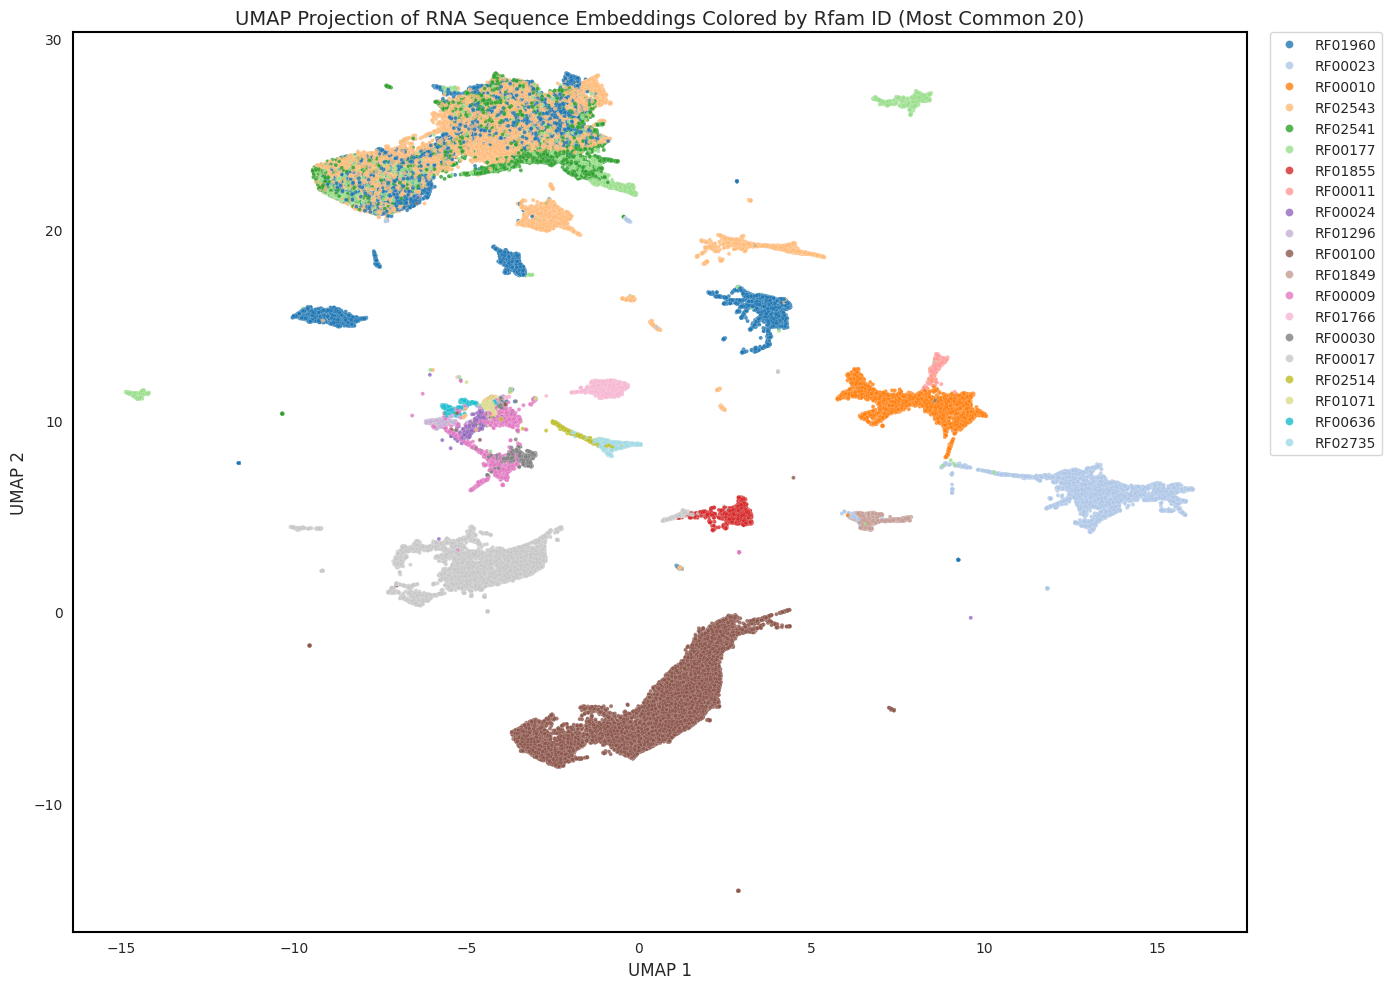

In [8]:
df_plot = pd.DataFrame(X_embedded, columns=['x', 'y']) #table for UMAP coordinates
df_plot['Rfam_ID'] = rfam_ids['rfam_id'].values #add rfam id labels
top_n = 20 #this variable for most common 20 families
top_ids = df_plot['Rfam_ID'].value_counts().nlargest(top_n).index #find their names
df_plot_filtered = df_plot[df_plot['Rfam_ID'].isin(top_ids)] #keep only the top 20
plt.figure(figsize=(14, 10)) #set figure size and canvas
sns.set_style("white") #set background
ax = sns.scatterplot(
    data=df_plot_filtered,
    x='x',
    y='y',
    hue='Rfam_ID',
    palette='tab20',   
    s=8,               
    alpha=0.8,         
    edgecolor='white', 
    linewidth=0.1      
) #plot aesthetics
plt.xlabel("UMAP 1", fontsize=12) 
plt.ylabel("UMAP 2", fontsize=12)
plt.title("UMAP Projection of RNA Sequence Embeddings Colored by Rfam ID (Most Common 20)", fontsize=14) #titles
plt.legend(
    bbox_to_anchor=(1.02, 1), 
    loc='upper left', 
    borderaxespad=0,
    title=None,
    frameon=True,     
    fontsize=10,
    markerscale=2     
) #legend aesthetics

#the for loop is from the GPT to make the black border
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.5)
    
#save and show without cutting!
plt.tight_layout()
plt.savefig("rfam_umap_plot.png", dpi=600, bbox_inches='tight')
plt.show()

In [5]:
alignment_score_matrix = pd.read_csv("alignment_matrix_3_perfam.csv", index_col=0) #pairwise alignment matrix aren shared with me

In [14]:
ids = alignment_score_matrix.index.tolist() #get indices which are in row and column names 
X = torch.stack([representations[i] for i in ids]) #stack and get the required indices
X_norm = F.normalize(X, p=2, dim=1) #Scales every vector so its length is exactly 1. (check the cos similarit formula we are forcing 
#denominator to be 1 so it is only the dot product
cosine_sim_matrix = X_norm @ X_norm.T  # Performs Matrix Multiplication (@) between the matrix and its Transpose (.T).
cosine_sim_df = pd.DataFrame(
    cosine_sim_matrix.cpu().numpy(),
    index=ids,
    columns=ids
) #format it as pd df

In [18]:
#get the pd to numpy array
align_mat = alignment_score_matrix.values 
cos_mat = cosine_sim_df.values
iu = np.triu_indices_from(align_mat, k=1) # get the upper
x = align_mat[iu]   # alignment scores
y = cos_mat[iu]     # cosine similarities

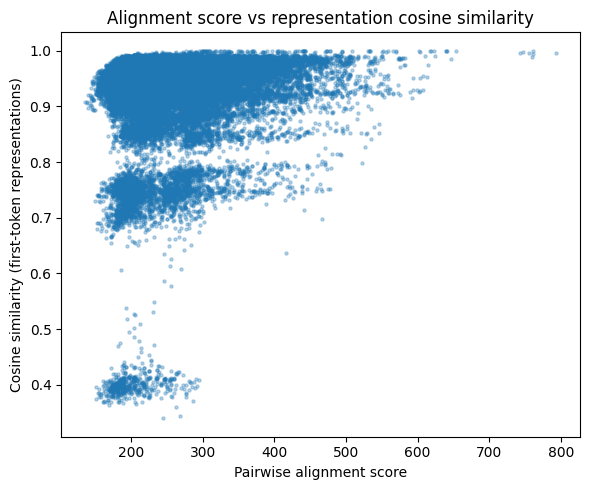

In [21]:
plt.figure(figsize=(6, 5))
plt.scatter(x, y, s=5, alpha=0.3)
plt.xlabel("Pairwise alignment score")
plt.ylabel("Cosine similarity (first-token representations)")
plt.title("Alignment score vs representation cosine similarity")
plt.tight_layout()
plt.savefig("scatter_plot_alignment_representation", dpi=600, bbox_inches='tight')
plt.show()